[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 19
[LightGBM] [Info] Start training from score 35174194.386364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

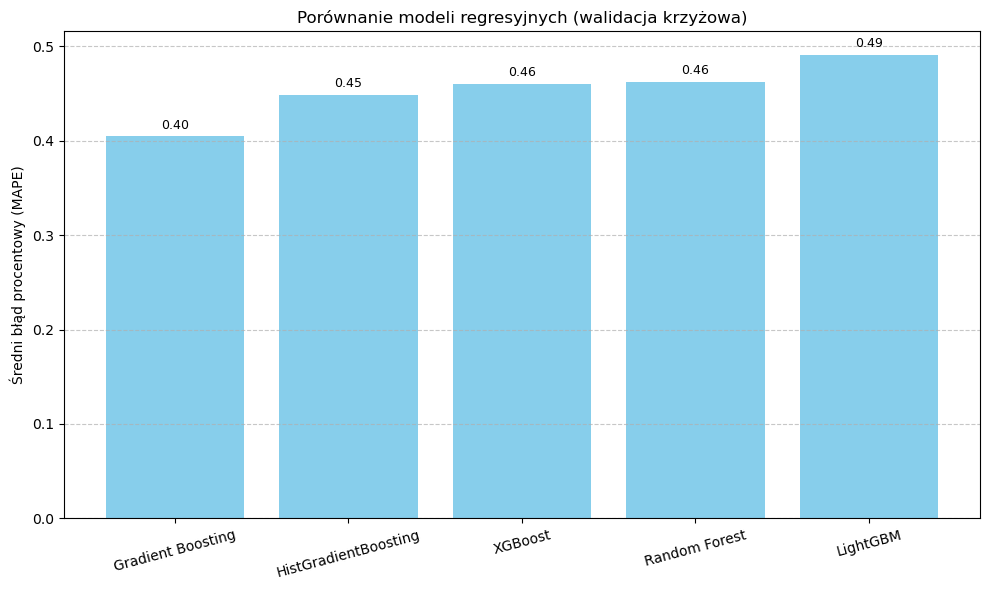

In [10]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie danych
path = "oczyszczone_dane_lotniska.xlsx"
df = pd.read_excel(path)

# Konwersja kolumn tekstowych zawierających liczby
columns_to_convert = [
    'pax', 'lotniska_300km', 'flota_komercyjna', 'pasy_startowe',
    'bramki', 'odprawy', 'autostrady_km', 'kolej_elektr_km',
    'ofiary_lotnicze', 'turystyka', 'lotniska_kraj',
    'pkb_pps', 'pkb_realny', 'powierzchnia_km2'
]

for col in columns_to_convert:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(' ', '', regex=False).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Uzupełnianie braków średnią dla danego lotniska
df_numeric = df.select_dtypes(include='number')
df_grouped = df_numeric.copy()
lotniska = df['lotnisko']

for col in df_numeric.columns:
    df_grouped[col] = df_numeric[col].fillna(df.groupby('lotnisko')[col].transform('mean'))

# Dodanie zmiennych przeliczonych na km2
pow = df_grouped['powierzchnia_km2']
df_grouped['autostrady_km_na_km2'] = df_grouped['autostrady_km'] / pow
df_grouped['kolej_elektr_km_na_km2'] = df_grouped['kolej_elektr_km'] / pow
df_grouped['turystyka_na_km2'] = df_grouped['turystyka'] / pow
df_grouped['lotniska_kraj_na_km2'] = df_grouped['lotniska_kraj'] / pow
df_grouped['pkb_pps_na_km2'] = df_grouped['pkb_pps'] / pow
df_grouped['pkb_realny_na_km2'] = df_grouped['pkb_realny'] / pow

X = df_grouped.drop(columns=['pax'])
y = df_grouped['pax']

# Lista modeli
models = {
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42)
}

# Walidacja krzyżowa
results = []
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring=mape_scorer, cv=5)
    mean_mape = -np.mean(scores)
    results.append({"Model": name, "MAPE (CV)": mean_mape})

# Posortowanie wyników rosnąco
results_df = pd.DataFrame(results).sort_values(by='MAPE (CV)')

# Wykres
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['MAPE (CV)'], color='skyblue')

# Dodanie wartości nad słupkami (zaokrąglenie do 2 miejsc po przecinku)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom', fontsize=9)

# Ustawienia wykresu
plt.ylabel('Średni błąd procentowy (MAPE)')
plt.title('Porównanie modeli regresyjnych (walidacja krzyżowa)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




